In [1]:
!pip install -q tensorflow
!pip install -q protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 8.8 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.1

In [2]:
import os
import zipfile
import random
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16

2025-11-09 19:26:58.767163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762716418.950851      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762716419.009425      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:


base = "/kaggle/input/dogs-vs-cats-redux-kernels-edition"
print("📂 Contenu du dossier de base :", os.listdir(base))

train_zip = os.path.join(base, "train.zip")
test_zip = os.path.join(base, "test.zip")

train_extract_path = "/kaggle/working/train"
test_extract_path = "/kaggle/working/test"

# Décompression train.zip
if not os.path.exists(train_extract_path) or len(os.listdir(train_extract_path)) == 0:
    print("📦 Extraction de train.zip...")
    with zipfile.ZipFile(train_zip, 'r') as zip_ref:
        zip_ref.extractall(train_extract_path)
    print("✅ train.zip décompressé avec succès")

# Décompression test.zip
if not os.path.exists(test_extract_path) or len(os.listdir(test_extract_path)) == 0:
    print("📦 Extraction de test.zip...")
    with zipfile.ZipFile(test_zip, 'r') as zip_ref:
        zip_ref.extractall(test_extract_path)
    print("✅ test.zip décompressé avec succès")

# 📸 Corrige le chemin s’il y a un sous-dossier "train" à l’intérieur
if "train" in os.listdir(train_extract_path):
    train_dir = os.path.join(train_extract_path, "train")
else:
    train_dir = train_extract_path

if "test" in os.listdir(test_extract_path):
    test_dir = os.path.join(test_extract_path, "test")
else:
    test_dir = test_extract_path


📂 Contenu du dossier de base : ['sample_submission.csv', 'train.zip', 'test.zip']
📦 Extraction de train.zip...
✅ train.zip décompressé avec succès
📦 Extraction de test.zip...
✅ test.zip décompressé avec succès


In [4]:
noms_fichiers = os.listdir(train_dir)

In [5]:
# Initialiser une liste pour les catégories
categories = []

# Boucle pour assigner les catégories
for filename in noms_fichiers:
    # Obtenir la partie avant le premier point du nom de fichier
    categorie = filename.split('.')[0]
    # Vérifier si cette partie est "dog"
    if categorie == 'dog':
        # Ajouter 1 à la liste categories (indiquant que c'est une image de chien)
        categories.append(1)
    else:
        # Ajouter 0 à la liste categories (indiquant que c'est une image de chat)
        categories.append(0)

In [6]:
# creer un dataframe avec pandas

df = pd.DataFrame ({
    'filename': noms_fichiers,
    'categorie': categories
})

# Afficher le dataframe
print(df.head())

        filename  categorie
0   cat.5431.jpg          0
1   dog.3778.jpg          1
2   dog.4337.jpg          1
3   cat.7020.jpg          0
4  dog.10699.jpg          1


In [7]:
# Sélectionner une image aléatoire
# Sélectionner une image aléatoire
image_aleatoire = random.choice(noms_fichiers)


# Chemin complet de l'image sélectionnée
img_path = os.path.join(train_dir, image_aleatoire)
img_path

'/kaggle/working/train/train/dog.9718.jpg'

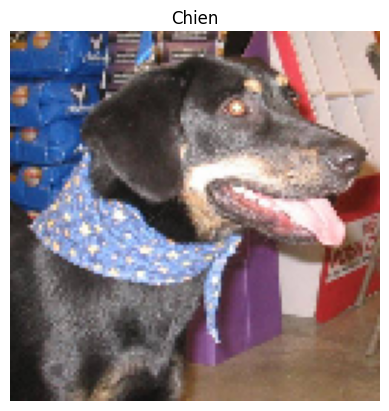

In [8]:
# Charger et afficher l'image
img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
categorie = 'Chien' if 'dog' in image_aleatoire else 'Chat'
plt.title(categorie)
plt.axis('off')
plt.show()

In [9]:
# Sélectionner aléatoirement 1500 images de chats (catégorie 0)
chats_df = df[df['categorie'] == 0].sample(n=1500, random_state=42)

# Sélectionner aléatoirement 1500 images de chiens (catégorie 1)
chiens_df = df[df['categorie'] == 1].sample(n=1500, random_state=42)

# Combiner les deux DataFrames
df_final = pd.concat([chats_df, chiens_df]).reset_index(drop=True)
df_final

,filename,categorie
0,cat.11042.jpg,0
1,cat.6159.jpg,0
2,cat.12347.jpg,0
3,cat.107.jpg,0
4,cat.7232.jpg,0
...,...,...
2995,dog.2011.jpg,1
2996,dog.7307.jpg,1
2997,dog.6667.jpg,1
2998,dog.6043.jpg,1


In [10]:
# Initialisation de la base convolutionnelle du modèle VGG16 préentraîné.
# weights='imagenet' signifie que le modèle est préentraîné sur l'ensemble de données ImageNet, qui contient des millions d'images annotées.
# include_top=False signifie que les couches de classification dense (top layers) ne sont pas incluses,
# ce qui permet d'utiliser le modèle comme un extracteur de caractéristiques sans la dernière couche de classification.
# input_shape=(150, 150, 3) définit la taille des images d'entrée attendues par le modèle (150x150 pixels avec 3 canaux pour RGB).
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

I0000 00:00:1762716448.338333      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Sélectionner aléatoirement 1500 images de chats (catégorie 0)
chats_df = df[df['categorie'] == 0].sample(n=1500, random_state=42)

# Sélectionner aléatoirement 1500 images de chiens (catégorie 1)
chiens_df = df[df['categorie'] == 1].sample(n=1500, random_state=42)

# Combiner les deux DataFrames
df_final = pd.concat([chats_df, chiens_df]).reset_index(drop=True)
df_final


# S'assurer que la colonne 'category' contient des chaînes de caractères
df_final['categorie'] = df_final['categorie'].astype(str)

In [13]:
# Diviser les données en ensembles d'entraînement et de test
df_train, df_test = train_test_split(df_final, test_size=0.2, random_state=42)

# Afficher la taille des ensembles d'entraînement et de test
print(f"Taille de l'ensemble d'entraînement : {df_train.shape[0]}")
print(f"Taille de l'ensemble de test : {df_test.shape[0]}")

Taille de l'ensemble d'entraînement : 2400
Taille de l'ensemble de test : 600


In [14]:
# Préparation des générateurs de données
# Appliquer des transformations et normaliser les images pour l'ensemble d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normaliser les valeurs des pixels
    rotation_range=40,       # Rotation aléatoire des images jusqu'à 40 degrés
    width_shift_range=0.2,   # Décalage horizontal aléatoire jusqu'à 20%
    height_shift_range=0.2,  # Décalage vertical aléatoire jusqu'à 20%
    shear_range=0.2,         # Cisaillement aléatoire
    zoom_range=0.2,          # Zoom aléatoire jusqu'à 20%
    horizontal_flip=True,    # Retourner les images horizontalement
    fill_mode='nearest'      # Mode de remplissage pour les nouveaux pixels
)



# Normaliser les images pour l'ensemble de validation
val_datagen = ImageDataGenerator(rescale=1./255)  # Normaliser les valeurs des pixels

In [15]:


# Générateur de données pour l'entraînement
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    directory=train_dir,  # Remplacez par le chemin du répertoire contenant les images d'entraînement
    x_col='filename',                  # Nom de colonne pour les noms de fichiers
    y_col='categorie',                  # Nom de colonne pour les catégories
    target_size=(150, 150),            # Redimensionner les images à 150x150 pixels
    batch_size=32,                     # Nombre d'images par lot
    class_mode='binary'                # Mode de classification binaire (chat ou chien)
)

# Générateur de données pour la validation
validation_generator = val_datagen.flow_from_dataframe(
    df_test,
    directory=train_dir,  # Remplacez par le chemin du répertoire contenant les images de validation
    x_col='filename',                  # Nom de colonne pour les noms de fichiers
    y_col='categorie',                  # Nom de colonne pour les catégories
    target_size=(150, 150),            # Redimensionner les images à 150x150 pixels
    batch_size=32,                     # Nombre d'images par lot
    class_mode='binary'                # Mode de classification binaire (chat ou chien)
)


Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [16]:
# Charger le modèle VGG16 pré-entraîné sans la couche supérieure (include_top=False)
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [17]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Geler toutes les couches sauf celles du bloc5_conv
for layer in conv_base.layers:
    if "block5" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False


In [19]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [20]:

# Ajouter des couches de classification au-dessus du modèle pré-entraîné
model = models.Sequential()                  # Initialiser un modèle séquentiel
model.add(conv_base)                         # Ajouter la base convolutive de VGG16
model.add(layers.Flatten())                  # Aplatir les sorties des convolutions
model.add(layers.Dense(256, activation='relu'))  # Ajouter une couche dense avec 256 unités et activation ReLU
model.add(layers.Dropout(0.5))               # Ajouter une couche de dropout pour réduire le surapprentissage
model.add(layers.Dense(1, activation='sigmoid')) # Ajouter une couche dense avec une unité de sortie et activation sigmoïde


In [21]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [22]:

# Compiler le modèle avec une perte binaire et un optimiseur RMSprop
model.compile(loss='binary_crossentropy',  # Utiliser la perte binaire cross-entropie
              optimizer=optimizers.RMSprop(learning_rate=2e-5),  # Utiliser l'optimiseur RMSprop avec un taux d'apprentissage réduit
              metrics=['accuracy'])        # Mesurer l'exactitude du modèle

# Entraîner le modèle
history = model.fit(
    train_generator,                        # Utiliser le générateur de données d'entraînement
    steps_per_epoch=50,  # Nombre de pas par époque
    epochs=30,                              # Nombre d'époques d'entraînement
    validation_data=validation_generator   # Utiliser le générateur de données de validation

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1762716452.888397     121 service.cc:148] XLA service 0x7b4c74003120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762716452.889335     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762716453.292916     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/50 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5859 - loss: 0.7564

I0000 00:00:1762716459.005768     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - accuracy: 0.6254 - loss: 0.6741 - val_accuracy: 0.8417 - val_loss: 0.4005
Epoch 2/30
25/50 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.7436 - loss: 0.5066

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7468 - loss: 0.5018 - val_accuracy: 0.8433 - val_loss: 0.3754
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.7948 - loss: 0.4393 - val_accuracy: 0.8717 - val_loss: 0.3228
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8168 - loss: 0.3703 - val_accuracy: 0.8717 - val_loss: 0.3316
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.8411 - loss: 0.3596 - val_accuracy: 0.8933 - val_loss: 0.2607
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8571 - loss: 0.3289 - val_accuracy: 0.8950 - val_loss: 0.2564
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.8717 - loss: 0.3030 - val_accuracy: 0.8967 - val_loss: 0.2648
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8832 - loss: 0.2621 - val_accuracy: 0.8950 - val_loss: 0.2630
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.8937 - loss: 0.2627 - val_accuracy: 0.9017 - v

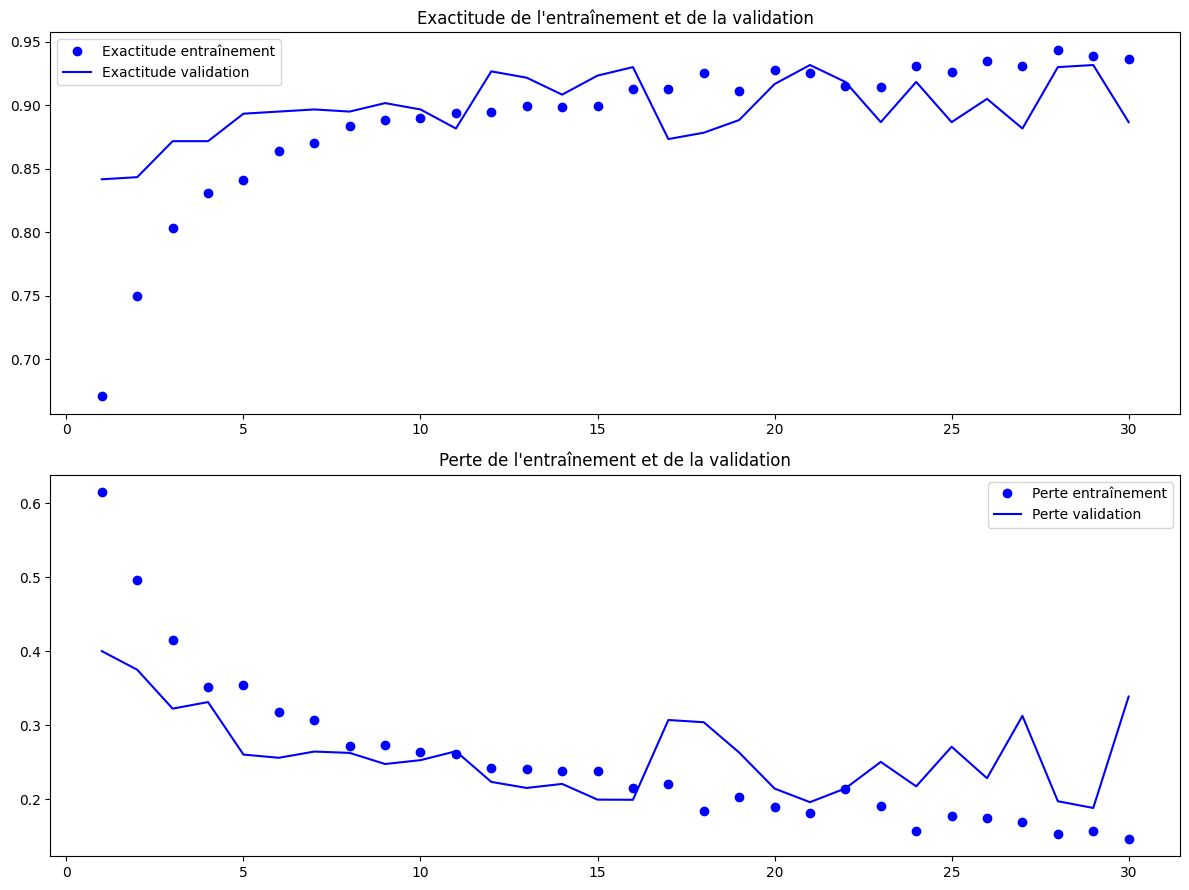

In [23]:

# Courbes de validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))

# Courbe de l'exactitude
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, 'bo', label='Exactitude entraînement')
plt.plot(epochs, val_acc, 'b', label='Exactitude validation')
plt.title("Exactitude de l'entraînement et de la validation")
plt.legend()

# Courbe de la perte
plt.subplot(2, 1, 2)
plt.plot(epochs, loss, 'bo', label='Perte entraînement')
plt.plot(epochs, val_loss, 'b', label='Perte validation')
plt.title("Perte de l'entraînement et de la validation")
plt.legend()

plt.tight_layout()
plt.show()


In [24]:

# Évaluer le modèle sur l'ensemble de validation
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")  # Afficher l'exactitude de validation en pourcentage

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8879 - loss: 0.3366
Validation Accuracy: 88.67%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


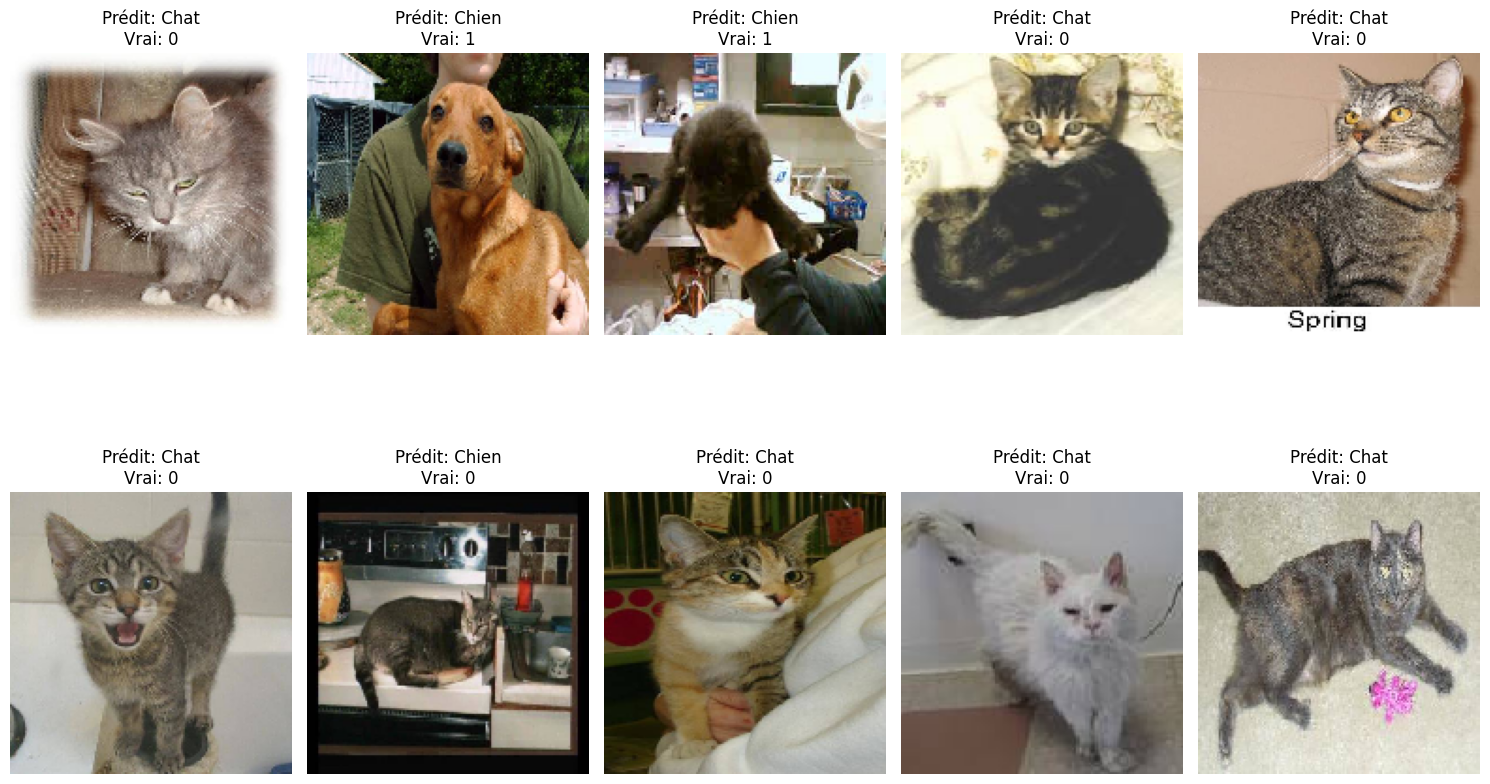

In [26]:
# Prédictions sur 10 images
sample_images = df_test.sample(10).reset_index(drop=True)  # Échantillonner 10 images de validation

plt.figure(figsize=(15, 10))
for i, row in sample_images.iterrows():
    img_path = os.path.join(train_dir, row['filename'])
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img) / 255.0
    img_tensor = np.expand_dims(img_tensor, axis=0)

    prediction = model.predict(img_tensor)
    prediction_label = 'Chien' if prediction[0] > 0.5 else 'Chat'

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Prédit: {prediction_label}\nVrai: {row['categorie']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [27]:
# Sauvegarder le modèle entraîné
model.save('cats_and_dogs_small_vgg16.h5')